In [2]:
# Import required libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

# Set figure parameters
mpl.rc("savefig", dpi=300)
sc.set_figure_params(dpi_save=150, frameon=False, vector_friendly=True,
                     fontsize=6, figsize=(3,3), format='pdf', transparent=True)
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)

# Style settings
sns.set_style("ticks")
plt.style.use('../bursa.mplstyle')

# File output configurations
output_dir = "../../figures/shared_mb/"
output_suffix = ""
output_formats = [".png", ".pdf"]
savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.1,
    "transparent": True,
}

# Run helper script
%run ../helper.py


## fxns

In [3]:
def save_figure(
    fig,
    name,
    output_dir=output_dir,
    output_suffix=output_suffix,
    output_formats=output_formats,
    savefig_args=savefig_args,
):
    for output_format in output_formats:
        fig.savefig(
            output_dir + "/" + name + output_suffix + output_format, **savefig_args
        )
    return None

In [4]:
# Function to plot feature importances
def plot_feature_importances(importances, feature_names, title):
    # Sort the features based on their importances
    sorted_indices = np.argsort(importances)[::-1]
    sorted_features = np.array(feature_names)[sorted_indices]
    sorted_importances = importances[sorted_indices]
    
    # Create a DataFrame for easier plotting with Seaborn
    data = pd.DataFrame({'Feature': sorted_features, 'Importance': sorted_importances})
    
    # Initialize the Seaborn plot
    fig, ax = plt.subplots(figsize=(1.25, 2.5))
    
    # Use Seaborn to plot the bar chart
    sns.barplot(x='Importance', y='Feature', data=data, ax=ax, orient='h', color = 'k')
    ax.tick_params(axis='both', which = 'minor', size = 0)
    # Add labels and title
    plt.xlabel('Importance\n(Regression Coefficient)')
    plt.ylabel('Feature')
    plt.title(title)
    return fig

## load clean and transform data for classifier



In [5]:
# configuration
h5ad = 'TBd6_sharing.h5ad.gz'
mb_only = True
as_only = not mb_only
mb_ids = "Memory B|Age-|Prolif"
as_ids = "Plasma"
tissue_relationship = "LN_LN"
use_meta = False
gene_feature_sets = [f'{tissue_relationship}/mb_cells_filtered_de_genes_true.tab', f'{tissue_relationship}/mb_cells_filtered_de_genes_false.tab']
clf_data = "classifier_data.tab"

In [6]:
ad = sc.read_h5ad(h5ad)
if mb_only:
    ad = ad[ad.obs.celltypist.str.contains(mb_ids, regex=True)]
if as_only:
    ad = ad[ad.obs.celltypist.str.contains(as_ids, regex=True)]

In [19]:
dedf = pd.read_table(gene_feature_sets[0], index_col=0)


In [21]:
dedf.names.dropna()

7         SAMSN1
8          ABCG1
14          RGS1
20         NR4A3
21          HCST
23          CD1C
25       FAM177B
40     STX17-AS1
66       TMEM163
111         CKLF
Name: names, dtype: object

In [12]:
# covert probable boolean strings to actual booleans (due to writing strings issue with adata.write_h5ad())
ad.obs = convert_boolean_columns(ad.obs)
# create column for whether any memory B cell is shared between any of the tissue combos
# binarize
ad.obs.shared = ad.obs[f"shared_{tissue_relationship}"]
print(ad.obs.shared.value_counts().xs(True), "shared B cells")
print(ad.obs.shared.value_counts().xs(False), "not shared B cells")
# extract feature set from DEG analysis
dedf = pd.read_table(gene_feature_sets[0], index_col=0)
shared_genes = dedf.dropna(subset='names').names[:20]
dedf = pd.read_table(gene_feature_sets[1], index_col=0)
non_shared_genes = dedf.dropna(subset = 'names')['names'].iloc[:15]
include_non_shared = True
if include_non_shared:
    feature_genes = list(shared_genes) + list(non_shared_genes)
else:
    feature_genes = list(shared_genes)

1022 shared B cells
8563 not shared B cells


# Set up for building classifier

In [13]:
tissue_combo_to_column = {
    'LN_LN': 'shared_LN_LN',
    'LN_SP': 'shared_LN_SP',
    'LN_PB': 'shared_LN_PB',
    'SP_PB' : 'shared_SP_PB',
    "BM_PB": 'shared_BM_PB'
    # Add more mappings as needed
}
response_vars = list(tissue_combo_to_column.values())
# add non gene variables to the classifier
if use_meta:
    meta_vars = ['switched', 'v_mismatch', 'celltypist']
else:
    meta_vars = []
#canonical = ['CD27', 'TCL1A', 'PSME2', "MKI67", "CD38", 'SELENOM', "IGHG1", "CD55", 'CR2']

In [14]:
features = feature_genes +  meta_vars + response_vars
df = sc.get.obs_df(ad, keys = features)
df.to_csv(clf_data, sep = '\t')

# Classification

Random Forest Accuracy: 0.5574572127139364
Random Forest Classification Report:               precision    recall  f1-score   support

       False       0.53      0.60      0.56       193
        True       0.59      0.52      0.56       216

    accuracy                           0.56       409
   macro avg       0.56      0.56      0.56       409
weighted avg       0.56      0.56      0.56       409

Logistic Regression Accuracy: 0.5843520782396088
Logistic Regression Classification Report:               precision    recall  f1-score   support

       False       0.55      0.64      0.59       193
        True       0.62      0.53      0.58       216

    accuracy                           0.58       409
   macro avg       0.59      0.59      0.58       409
weighted avg       0.59      0.58      0.58       409



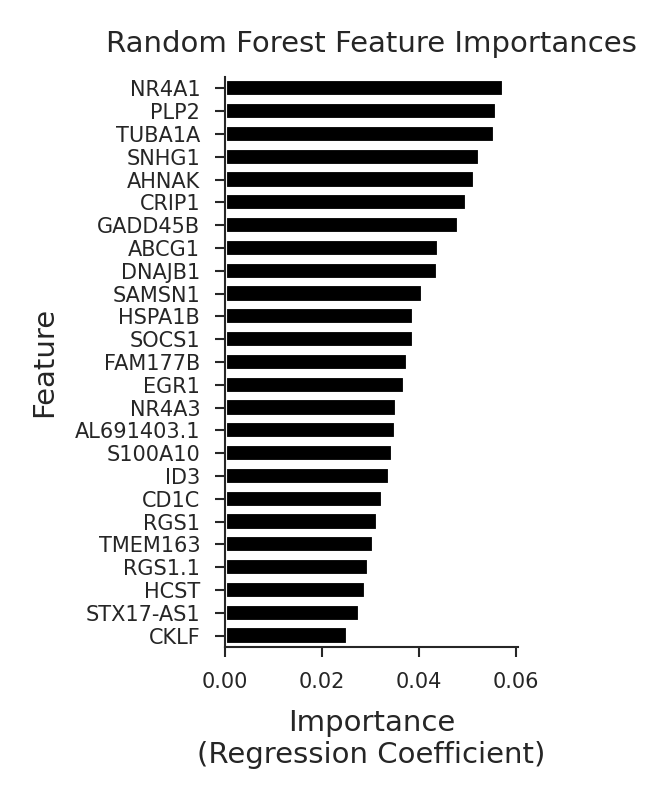

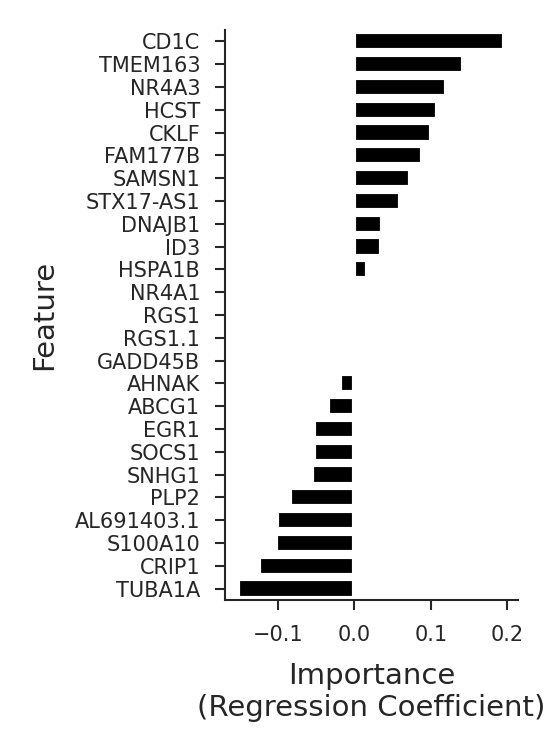

In [15]:
# Load the dataset
df = pd.read_table(clf_data)

# set 'shared' column according to logic
shared_column = f"shared_{tissue_relationship}"
df['shared'] = df[shared_column]
# remove other sharing columns
for val in tissue_combo_to_column.values():
    df.pop(val)

# Drop rows with NaN values in the 'shared' column
df.dropna(subset=['shared'], inplace=True)

# Convert the 'shared' column to integers
df['shared'] = df['shared'].astype(bool)

# Drop index column
df = df.drop(columns=['cb_suid'])

if use_meta:
    # remove celltypist column:
    df.pop('celltypist')
# Label encode 'switched'
    label_encoder = LabelEncoder()
    df['switched'] = label_encoder.fit_transform(df['switched'])
# One-hot encode 'celltypist'
# df = pd.get_dummies(df, columns=['subtype'], drop_first=True)

# Count the number of occurrences of each class
class_counts = df['shared'].value_counts()

# Identify the majority and minority classes
majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()

# Separate the data by class
df_majority = df[df['shared'] == majority_class]
df_minority = df[df['shared'] == minority_class]

# Undersample the majority class
df_majority_undersampled = df_majority.sample(len(df_minority))

# Concatenate the majority-undersampled and minority dataframes
df_undersampled = pd.concat([df_majority_undersampled, df_minority])

# Shuffle the DataFrame
df_undersampled = df_undersampled.sample(frac=1).reset_index(drop=True)

# Split the dataset into features (X) and target variable (y)
X = df_undersampled.drop('shared', axis=1)
y = df_undersampled['shared']

# Scale the features for clustering and logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

# Evaluate Random Forest
rf_y_pred = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_classification_rep = classification_report(y_test, rf_y_pred)

# Feature importances for Random Forest
rf_feature_importances = rf_clf.feature_importances_

# Initialize and train Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Evaluate Logistic Regression
log_y_pred = log_reg.predict(X_test)
log_accuracy = accuracy_score(y_test, log_y_pred)
log_classification_rep = classification_report(y_test, log_y_pred)

# Feature importances for Logistic Regression (coefficients)
log_feature_importances = log_reg.coef_[0]

# Print evaluation metrics
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Classification Report:", rf_classification_rep)
print("Logistic Regression Accuracy:", log_accuracy)
print("Logistic Regression Classification Report:", log_classification_rep)

# Plot feature importances
fig1 = plot_feature_importances(rf_feature_importances, X.columns, 'Random Forest Feature Importances')
fig2 = plot_feature_importances(log_feature_importances, X.columns, '')
save_figure(fig2, "LogisticRegression_Feature_Importance")

In [50]:
decision_scores = log_reg.decision_function(X)
plt_df = pd.DataFrame(decision_scores, columns=['lr_score'])
plt_df['shared'] = y

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [51]:
plt_df

,lr_score,shared
0,0.170189,True
1,0.290940,True
2,0.669577,True
3,-0.009958,True
4,0.501228,True
...,...,...
2039,0.171913,True
2040,0.334719,True
2041,0.123428,False
2042,0.148946,True


/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


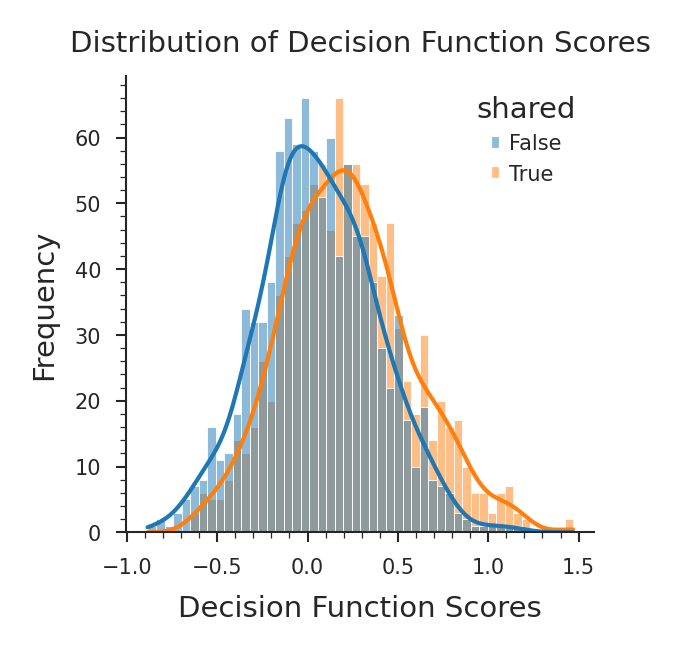

In [52]:
log_probs = log_reg.predict_log_proba(X)
probs = np.exp(log_probs)/(1 + np.exp(log_probs))
probs = probs.T[1]/(probs.T[0]+probs.T[1])
sns.histplot(plt_df, x = plt_df['lr_score'], bins=50, kde=True, hue='shared')
plt.xlabel('Decision Function Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Decision Function Scores')
plt.show()

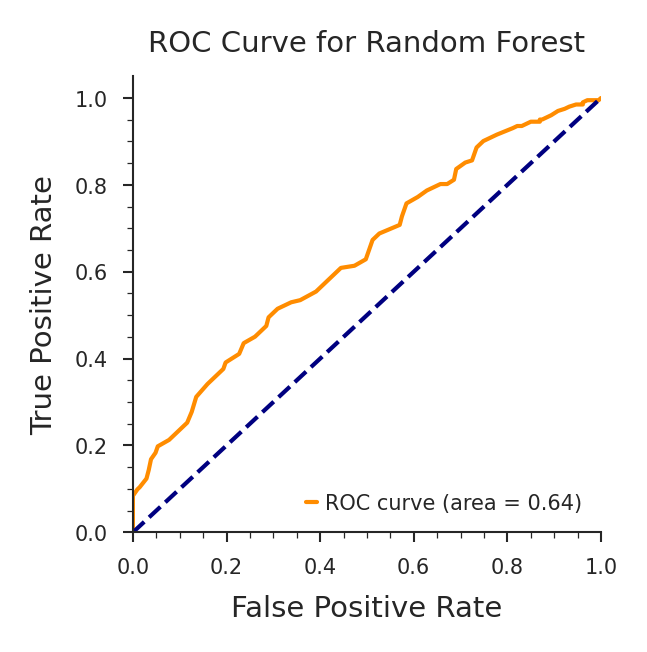

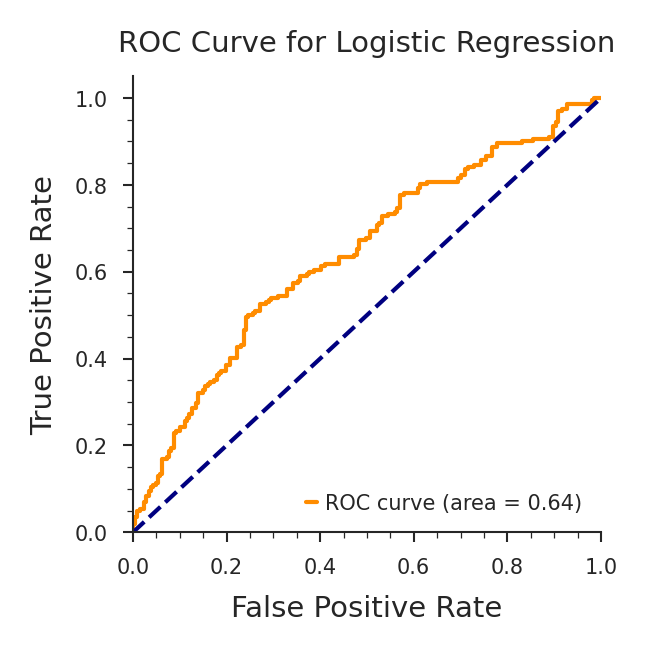

SVM Accuracy: 0.60880195599022
SVM Classification Report:               precision    recall  f1-score   support

       False       0.62      0.59      0.61       207
        True       0.60      0.62      0.61       202

    accuracy                           0.61       409
   macro avg       0.61      0.61      0.61       409
weighted avg       0.61      0.61      0.61       409



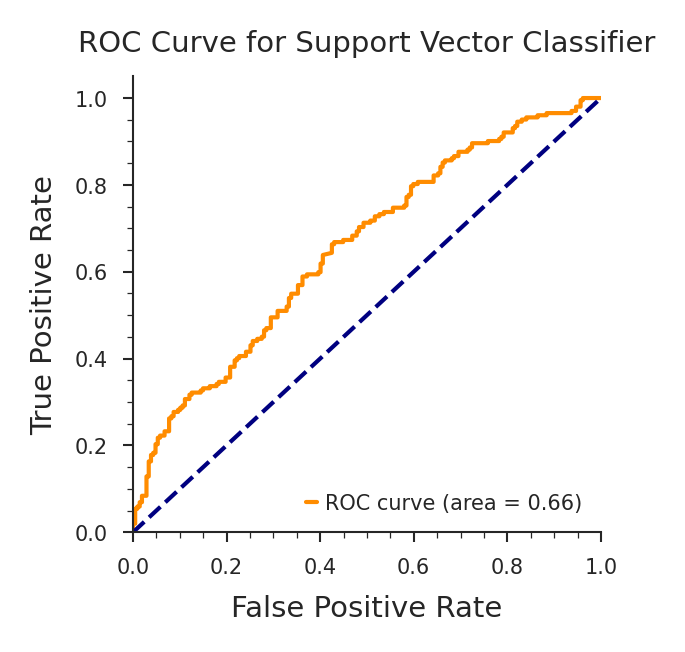

In [ ]:
# Function to plot ROC curve and AUC
def plot_roc_auc(y_test, y_pred_prob, model_name):

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    roc_auc = auc(fpr, tpr)

    plt.figure()

    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = {:.2f})'.format(roc_auc))

    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

    plt.xlim([0.0, 1.0])

    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')

    plt.ylabel('True Positive Rate')

    plt.title(f'ROC Curve for {model_name}')

    plt.legend(loc="lower right")

    plt.show()

# Predict probabilities for Random Forest

rf_y_pred_prob = rf_clf.predict_proba(X_test)[:, 1]

# Predict probabilities for Logistic Regression

log_y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

# Plot ROC curve and AUC for Random Forest

plot_roc_auc(y_test, rf_y_pred_prob, 'Random Forest')

# Plot ROC curve and AUC for Logistic Regression

plot_roc_auc(y_test, log_y_pred_prob, 'Logistic Regression')
# Importing the necessary library for Support Vector Machine (SVM)

# Initialize and train the Support Vector Classifier
svm_clf = SVC(probability=True, random_state=42)  # Setting probability=True to enable probability estimates
svm_clf.fit(X_train, y_train)

# Evaluate the Support Vector Classifier
svm_y_pred = svm_clf.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_y_pred)
svm_classification_rep = classification_report(y_test, svm_y_pred)

# Predict probabilities for Support Vector Classifier
svm_y_pred_prob = svm_clf.predict_proba(X_test)[:, 1]

# Print evaluation metrics for SVM
print("SVM Accuracy:", svm_accuracy)
print("SVM Classification Report:", svm_classification_rep)

# Plot ROC curve and AUC for Support Vector Classifier
plot_roc_auc(y_test, svm_y_pred_prob, 'Support Vector Classifier')


In [ ]:
df = pd.read_table(clf_data)

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  

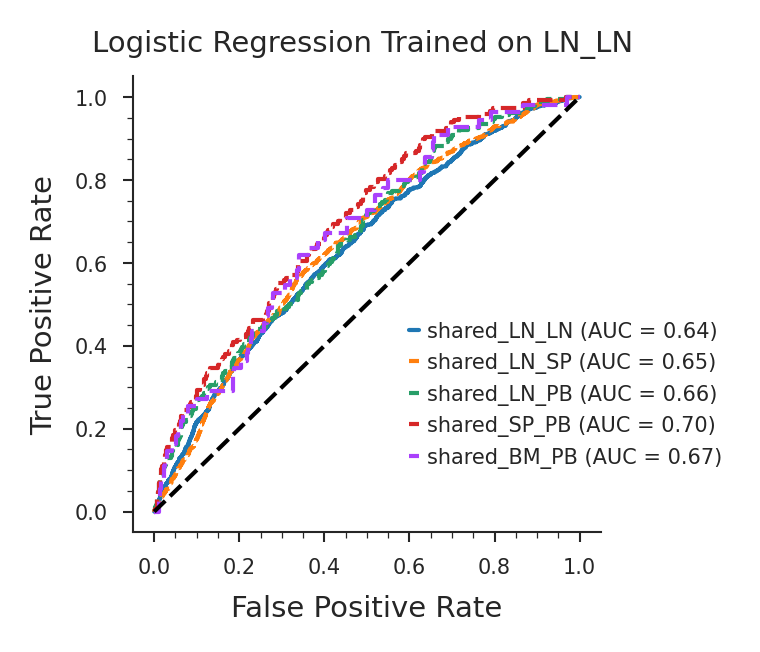

In [ ]:
# Function to plot ROC curve and AUC
def plot_roc_auc(y_true, y_pred_prob, label, ax):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    linestyle = '--'  # Default to dotted line
    if label.endswith(tissue_relationship):
        linestyle = '-'  # Solid line for LN_LN
    ax.plot(fpr, tpr, linestyle=linestyle, label=f'{label} (AUC = {roc_auc:.2f})')

# Initialize a plot for the ROC curves
fig, ax = plt.subplots()

# Dummy tissue_combo_to_column and clf_data for demonstration
# Replace these with your actual variables

# Loop through all tissue_combo_to_column values
for val in tissue_combo_to_column.values():
    # Read data into dataframe (replace with your actual data)
    df = pd.read_table(clf_data)
    
    # Rename the column to 'shared'
    df['shared'] = df[val]
    
    # Remove shared_X_X columns
    for col in tissue_combo_to_column.values():
        if col in df:
            df.pop(col)
    # remove celltyipst:
    df.pop('celltypist')
    # Drop rows with NaN values in the 'shared' column
    df.dropna(subset=['shared'], inplace=True)
    
    # Convert the 'shared' column to integers
    df['shared'] = df['shared'].astype(bool)
    
    # Drop index column
    df = df.drop(columns=['cb_suid'])
    
    # Label encode 'switched'
    label_encoder = LabelEncoder()
    df['switched'] = label_encoder.fit_transform(df['switched'])
    
    X_test = df.iloc[:, :-1]
    y_test = df.iloc[:, -1]
    
    # Predict probabilities for Logistic Regression
    log_y_pred_prob = log_reg.predict_proba(X_test)[:, 1]
    
    # Plot ROC curve and AUC for Logistic Regression on the same plot
    plot_roc_auc(y_test, log_y_pred_prob, f'{val}', ax)

# Add a dotted line at unity
ax.plot([0, 1], [0, 1], 'k--')

# Customize the plot
ax.set_title(f'Logistic Regression Trained on {tissue_relationship} ')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right', bbox_to_anchor = (1.3,0.1))

# Show the plot
plt.show()
save_figure(fig, "AUC_logistic_regression")


# show score

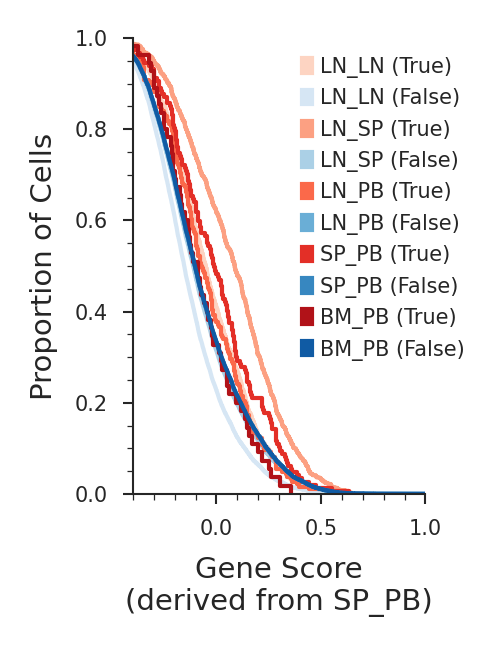

In [37]:
# Import required libraries
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns

# Score genes and prepare DataFrame for plotting
sc.tl.score_genes(ad, gene_list=feature_genes[:20], score_name="shared_score")
plt_df = sc.get.obs_df(ad, keys=['shared_score'] + list(tissue_combo_to_column.values()))

# Convert columns to categorical types, except 'shared_score'
for col in plt_df.columns:
    if col != 'shared_score':
        plt_df[col] = plt_df[col].astype('category')

# Create consolidated color mapping
consolidated_color_mapping = {}
true_colors = sns.color_palette("Reds", n_colors=len(tissue_combo_to_column))
false_colors = sns.color_palette("Blues", n_colors=len(tissue_combo_to_column))

for idx, tissue_combo in enumerate(tissue_combo_to_column.keys()):
    consolidated_color_mapping[tissue_combo_to_column[tissue_combo]] = {
        True: true_colors[idx],
        False: false_colors[idx]
    }

# Initialize plot and legend handles
fig, ax = plt.subplots(1, 1, figsize = (1.25, 2))
legend_handles = []

# Plot ECDF for each tissue_combo
for tissue_combo, column_name in tissue_combo_to_column.items():
    sns.ecdfplot(
        data=plt_df,
        x='shared_score',
        hue=column_name,
        ax=ax,
        palette=consolidated_color_mapping[column_name],
        stat='proportion',
        log_scale=(False, False),
        complementary=True
    )

    # Add custom legend entries
    for truth_value, color in consolidated_color_mapping[column_name].items():
        label = f"{tissue_combo} ({truth_value})"
        handle = mpatches.Patch(color=color, label=label)
        legend_handles.append(handle)

# Customize plot and save
ax.legend(handles=legend_handles, bbox_to_anchor=(1.2, 1))
ax.set_xlabel("Gene Score\n(derived from SP_PB)")
ax.set_ylabel("Proportion of Cells")
ax.set_xlim(-0.4, 1)
save_figure(fig, "ecdf_pan_shared_score_mb")


## Check on all donors